<a href="https://colab.research.google.com/github/bilzard/JQuants-news/blob/main/Ex01_JQuants_news_evaluation_1st_week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに

評価期間第一週に提出した全参加者のスコアの分布と、提出したモデルの統計的な特徴について簡単に調べてみました。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

データソースはSIGNATEのPrivateLBをコピペしたものを加工して作っています。

In [116]:
lb_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JPX_Competition/JQuants-news_leaderboard.csv')

In [117]:
lb_df = lb_df.replace({'-': np.nan}).dropna()
lb_df['最終評価 ▼'] = lb_df['最終評価 ▼'].astype(float)
lb_df['暫定評価'] = lb_df['暫定評価'].astype(float)
lb_df['推論時間 (sec)'] = lb_df['推論時間 (sec)'].astype(float)
lb_df['投稿件数'] = lb_df['投稿件数'].astype(float)

lb_df.rename(columns={'最終評価 ▼': 'Private LB', '推論時間 (sec)': 'PredTimeSec', '暫定評価': 'Public LB', '投稿件数': 'Submitions'}, inplace=True)

In [118]:
lb_df.head()

,順位,チーム名 / ユーザ名,PredTimeSec,Public LB,Private LB,Submitions,投稿日時,term
0,1,Ken.Ken.,5198.650,25701.3,-6114.4,1.0,2021-05-17 19:26:15,1
1,2,nakayasu,5112.404,60157.0,-12551.0,5.0,2021-05-17 19:26:14,1
2,3,FYSignate1009,332.109,27829.0,-16534.0,3.0,2021-05-17 17:54:05,1
3,4,takyan,6481.370,23375.0,-17608.0,3.0,2021-05-17 19:36:04,1
4,5,client_first,11.917,87766.3,-19128.9,15.0,2021-05-17 17:51:20,1


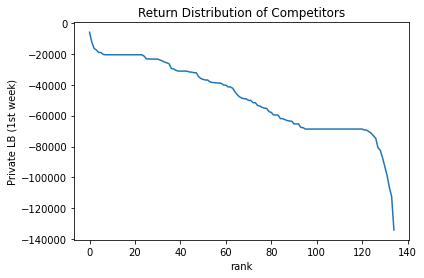

In [119]:
df = lb_df['Private LB']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(df)
ax.set_xlabel('rank')
ax.set_ylabel('Private LB (1st week)')

ax.title.set_text('Return Distribution of Competitors')

まず、第一週のPrivate LB のスコアをプロットします。
特異な2山の分布をしていますが、-2.0万円と-6.8万円付近にあるピークは、チュートリアルのモデルをそのまま提出したユーザの一群とおもわれます。

mean: -48286
std: 23399
p90: -20675
median: -48685


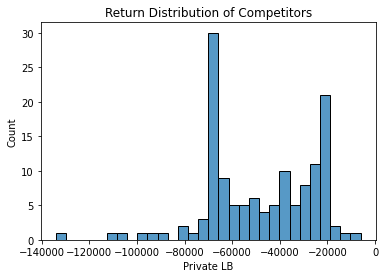

In [120]:
df = lb_df['Private LB']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(df, bins=30, ax=ax)
ax.title.set_text('Return Distribution of Competitors')

print(f'mean: {df.mean():.0f}')
print(f'std: {df.std():.0f}')
print(f'p90: {df.quantile(.9):.0f}')
print(f'median: {df.median():.0f}')

チュートリアルのモデルを除外した分布もプロットします。

mean: -47624
std: 23335
p90: -23404
median: -41877


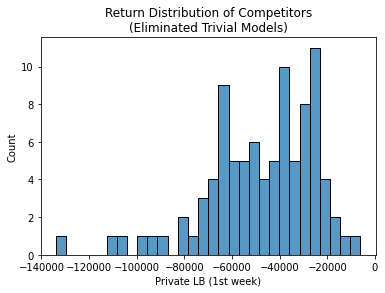

In [147]:
filter_tutorial = (lb_df['Private LB']!= -20675.0) & (lb_df['Private LB'] != -68681.0)
df = lb_df.loc[filter_tutorial, 'Private LB']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(df, bins=30, ax=ax)
ax.set_xlabel('Private LB (1st week)')
ax.title.set_text('Return Distribution of Competitors\n(Eliminated Trivial Models)')

print(f'mean: {df.mean():.0f}')
print(f'std: {df.std():.0f}')
print(f'p90: {df.quantile(.9):.0f}')
print(f'median: {df.median():.0f}')

## 提出したモデルの統計的特徴

参考までに、推論時間、Submission回数、Public LB, Private LB の4項目について相関をみてみます（以下の分析ではチュートリアルのモデルのスコアを除外しています）。

In [142]:
filter_tutorial = (lb_df['Private LB']!= -20675.0) & (lb_df['Private LB'] != -68681.0)
df = lb_df.loc[filter_tutorial, ['PredTimeSec', 'Submitions', 'Public LB', 'Private LB']]
df.corr('pearson')

,PredTimeSec,Submitions,Public LB,Private LB
PredTimeSec,1.000000,-0.040343,-0.321238,0.143265
Submitions,-0.040343,1.000000,0.381385,-0.164033
Public LB,-0.321238,0.381385,1.000000,-0.187262
Private LB,0.143265,-0.164033,-0.187262,1.000000


推論時間とPrivate LB に若干正の相関があります。第一週の評価では長考型モデルのほうが即答型のモデルに若干勝っています。

また、Public LB と Private LB は逆相関になっています。要因としては、Publicスコアが高いモデルは期待値が高くてリスクの高いポートフォリオを組んでいると思われるため、マイナスに触れたときのロスが大きいこと、また、Public のスコアに対して過学習してしまったことなどが考えられます。

興味深いことに、Submissioins と Public LB かなり強い正の相関があります。Public LB を改善するためにSubmissionを重ねたユーザが一定数いたことが想像できます。
今回のコンペは課題の性質からいうと、Public LB のスコアはあまりあてにならなかったのですが、目に見えるスコアをよくしたい、という心理が働いたのかもしれません。

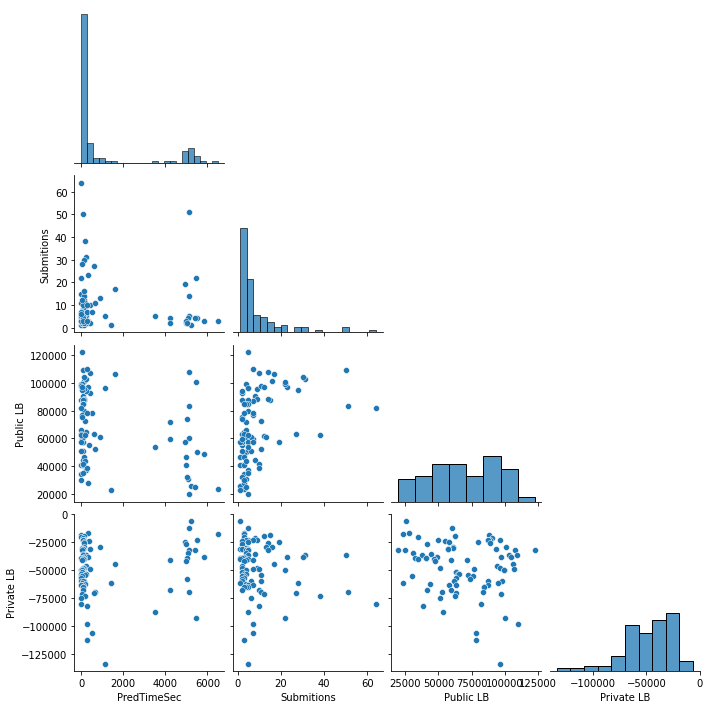

In [144]:
filter_tutorial = (lb_df['Private LB']!= -20675.0) & (lb_df['Private LB'] != -68681.0)
df = lb_df.loc[filter_tutorial, ['PredTimeSec', 'Submitions', 'Public LB', 'Private LB']]
sns.pairplot(df, corner=True)

## 最後に

第一週は残念ながらすべてのモデルがマイナス評価となりました。
学習に使った特徴量では説明のつかない要因によって、市場が大きく影響を受けたことが想像できます（詳しい原因の分析と考察は専門家におまかせします）。

第二週はプラス評価のモデルが出ることを祈ります。